In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define the folder containing the battery data files
data_folder = r'9. BatteryAgingARC_53_54_55_56/'

# Get a list of files in the folder
files = [f for f in os.listdir(data_folder) if f.endswith('.mat')]

In [76]:
# Loading all datasets from rated capacity to EOL
def load_data(battery):
    mat = loadmat(os.path.join(data_folder, battery + '.mat'))
    print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
    counter = 0
    dataset = []
    capacity_data = []

    max_capacity = 0

    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge':
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(int(row['time'][0][0]),
                                   int(row['time'][0][1]),
                                   int(row['time'][0][2]),
                                   int(row['time'][0][3]),
                                   int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            
            # Update max_capacity if the current capacity is greater
            if capacity > max_capacity:
                max_capacity = capacity
            # Filter dataset from rated capacity (100%) to EOL (70%)
            if capacity >= 0.65 * max_capacity:
                for j in range(len(data[0][0]['Voltage_measured'][0])):
                    voltage_measured = data[0][0]['Voltage_measured'][0][j]
                    current_measured = data[0][0]['Current_measured'][0][j]
                    temperature_measured = data[0][0]['Temperature_measured'][0][j]
                    current_load = data[0][0]['Current_load'][0][j]
                    voltage_load = data[0][0]['Voltage_load'][0][j]
                    time = data[0][0]['Time'][0][j]
                    dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                    voltage_measured, current_measured,
                                    temperature_measured, current_load,
                                    voltage_load, time])
                capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
            counter = counter + 1

    return pd.DataFrame(data=dataset,
                        columns=['cycle', 'ambient_temperature', 'datetime',
                                 'capacity', 'voltage_measured',
                                 'current_measured', 'temperature_measured',
                                 'current_load', 'voltage_load', 'time']), \
           pd.DataFrame(data=capacity_data,
                        columns=['cycle', 'ambient_temperature', 'datetime',
                                 'capacity'])

Total data in dataset:  137
Total data in dataset:  253
Total data in dataset:  252
Total data in dataset:  252


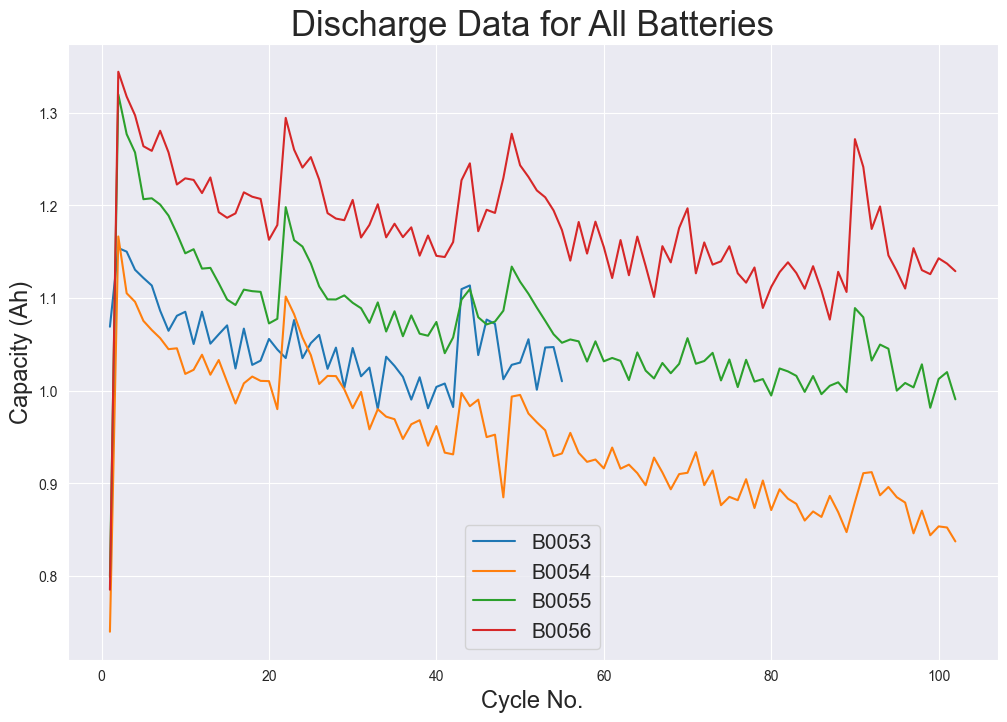

In [77]:
# Create a single chart to show the results for all batteries
plt.figure(figsize=(12, 8))
sns.set_style("darkgrid")

for battery in files:
    dataset, capacity = load_data(os.path.splitext(battery)[0])  # Use the file name without extension

    plot_df = capacity.loc[capacity['cycle'] >= 1, ['cycle', 'capacity']]

    # Plot the capacity data for each battery
    label = os.path.splitext(battery)[0]
    plt.plot(plot_df['cycle'], plot_df['capacity'], label=label)

plt.ylabel('Capacity (Ah)', fontsize = 17)
plt.xlabel('Cycle No.', fontsize = 17)
plt.title('Discharge Data for All Batteries', fontsize = 25)
plt.legend(fontsize = 15)

# Show the plot
plt.show()

In [78]:
def DF_analysis(data):
    # Extract the second digit of each value in the 'capacity' column
    first_digits = data['capacity'].astype(str).str[2]

    # Calculate the actual frequencies of each digit, ensuring all possible digits are included
    observed_freq = first_digits.value_counts(normalize=True).reindex([str(i) for i in range(0, 10)], fill_value=0)

    return observed_freq

Total data in dataset:  137
Total data in dataset:  253
Total data in dataset:  252
Total data in dataset:  252


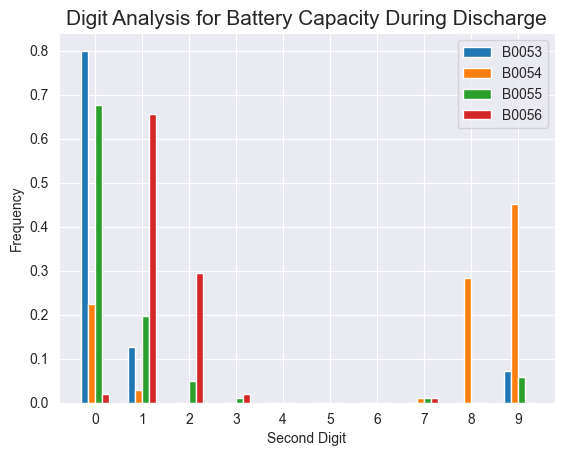

In [79]:
# Determine the width of each bar
bar_width = 0.15  # Adjust as needed

# Compute the number of files
num_files = len(files)

# Compute the horizontal positions for the bars
bar_positions = np.arange(0, 10)

# Iterate over each file, perform the analysis, and accumulate the observed frequencies
for i, file in enumerate(files):
    dataset, capacity = load_data(file[:-4])  # Remove the ".mat" extension
    observed = DF_analysis(capacity) 
    
    # Offset each histogram to avoid overlap
    offset = (i - (num_files - 1) / 2) * bar_width
    plt.bar(bar_positions + offset, observed.values, width=bar_width, label=file[:-4])

plt.xlabel("Second Digit")
plt.ylabel("Frequency")
plt.title("Digit Analysis for Battery Capacity During Discharge", fontsize = 15)
plt.xticks(range(0, 10))
plt.legend()
plt.show()

Total data in dataset:  137
Total data in dataset:  253
Total data in dataset:  137
Total data in dataset:  252
Total data in dataset:  137
Total data in dataset:  252
Total data in dataset:  253
Total data in dataset:  137
Total data in dataset:  253
Total data in dataset:  252
Total data in dataset:  253
Total data in dataset:  252
Total data in dataset:  252
Total data in dataset:  137
Total data in dataset:  252
Total data in dataset:  253
Total data in dataset:  252
Total data in dataset:  252
Total data in dataset:  252
Total data in dataset:  137
Total data in dataset:  252
Total data in dataset:  253
Total data in dataset:  252
Total data in dataset:  252


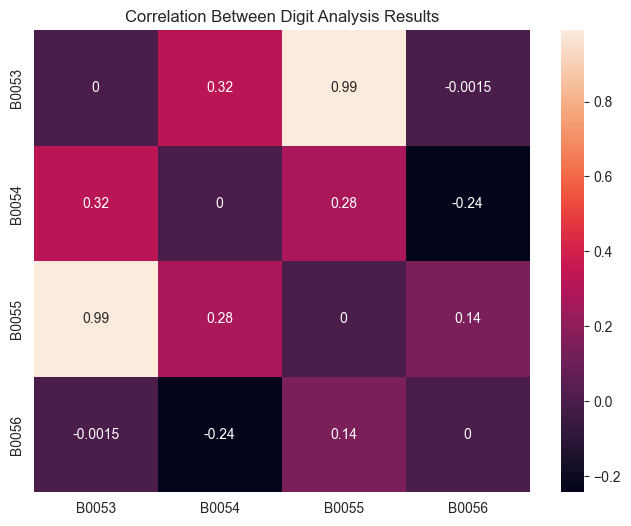

In [80]:
# Create an empty matrix to store the correlation coefficients
num_files = len(files)
correlation_matrix = np.zeros((num_files, num_files))

# Iterate over each file and calculate the correlation with other files
for i in range(num_files):
    for j in range(num_files):
        if i != j:
            observed_i = DF_analysis(load_data(files[i][:-4])[1])  # Extract capacity data and calculate observed frequencies
            observed_j = DF_analysis(load_data(files[j][:-4])[1])
            
            # Calculate the correlation coefficient (e.g., Pearson correlation)
            correlation = np.corrcoef(observed_i, observed_j)[0, 1]
            
            correlation_matrix[i, j] = correlation

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, xticklabels=[f[:-4] for f in files], yticklabels=[f[:-4] for f in files], annot=True)
plt.title("Correlation Between Digit Analysis Results")
plt.show()